## Generating Digit Images with a Variational Autoencoder

This notebook provides you with a complete code example that
trains a variational autoencoder on the MNIST digits and uses it to generated
new digit images and cluster the digits in the latent space.

## Loading the MNIST Dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

Import the MNIST dataset ...

In [1]:
import os
import deeptrack as dt

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

data_dir = os.path.join("MNIST_dataset", "mnist")
train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

Cloning into 'MNIST_dataset'...
Updating files: 100% (70003/70003), done.


... create an image pipeline ...

In [2]:
import torch

image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

... and plot some MNIST digits.

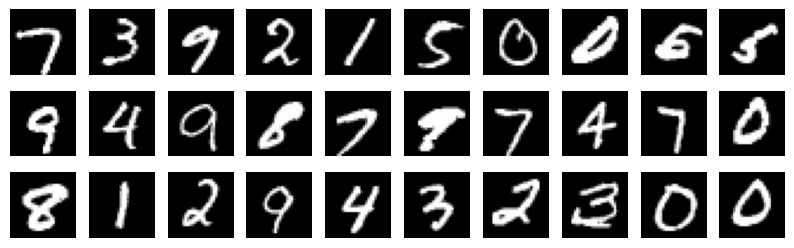

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(train_files, axs.size)):
    image = image_pipeline(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_axis_off()
plt.show()

## Training the Variational Autoencoder

Define the variational autoencoder ...

In [5]:
import deeplay as dl

vae = dl.VariationalAutoEncoder(
    latent_dim=2,
    channels=[32, 64],
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"),
    beta=1,
).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_f

... define the data loader ...

In [6]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(image_pipeline & image_pipeline,
                                   inputs=train_files)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

... train the variational autoencoder ...

In [7]:
vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
vae_trainer.fit(vae, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-03-24 06:15:08.414273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with 

Training: |          | 0/? [00:00<?, ?it/s]

## Generating Digit Images with the Decoder

In [ ]:
from torch.distributions.normal import Normal

img_num = 21
img_size = 28

z0_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z0_grid.numpy(), 1),
)
plt.yticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()

## Clustering the Digit Images in the Latent Space with the Encoder

Define a pipeline combining the test images and their digit values (labels) ...

In [ ]:
label_pipeline = dt.Value(files.label_name[0]) >> int
test_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=test_files)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

... encode the test images in the latent space ...

In [ ]:
mu_list, test_labels = [], []
for image, label in test_loader:
    mu, _ = vae.encode(image)
    mu_list.append(mu)
    test_labels.append(label)
mu_tensor = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

... plot the latent space.

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(mu_tensor[:, 0], mu_tensor[:, 1], s=3, c=test_labels, cmap="tab10")
plt.xlabel("mu_tensor[:, 0]")
plt.ylabel("mu_tensor[:, 1]")
plt.colorbar()
plt.gca().invert_yaxis()
plt.axis("equal")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.show()